<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/TS_week2_simple_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.3.0'

In [39]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

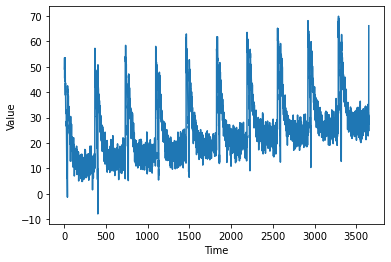

In [57]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [58]:
dataset = tf.data.Dataset.from_tensor_slices(series)

In [59]:
# for item in dataset:
#   print(item)

In [60]:
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

In [61]:
# for item in dataset:
#   print(item)

In [62]:
dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

In [63]:
# for item in dataset:
#   print(item)

In [64]:
dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))

In [83]:
# for item in dataset:
#   print(item)

In [66]:
dataset = dataset.batch(batch_size=batch_size).prefetch(1)

In [84]:
# for item in dataset:
#   print(item)

In [68]:
# tf.shape(dataset)

In [69]:
l0 = Dense(1, input_shape=[window_size])
model = Sequential([
                    l0
])

In [79]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['mse'])

history = model.fit(dataset, epochs=100, verbose=0)

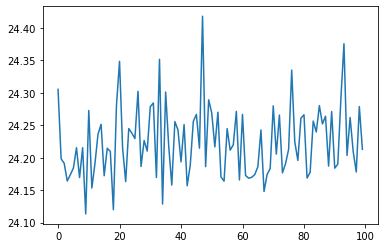

In [80]:
plt.plot(history.history['loss'])

In [81]:
series

array([49.12849 , 50.28806 , 53.549213, ..., 30.218498, 24.751186,
       66.11884 ], dtype=float32)

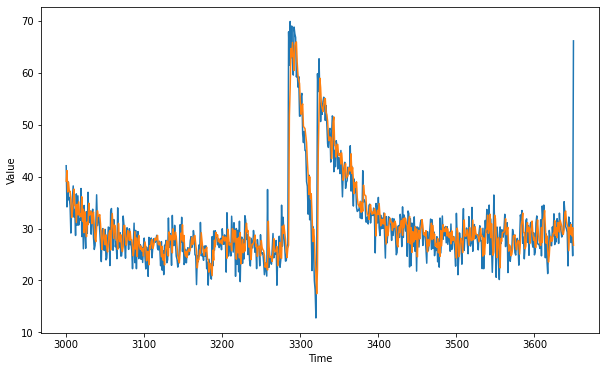

In [82]:

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)